In [25]:
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import yt
import glob
import matplotlib.pyplot as plt

In [6]:
def parse_ionDens(numberDens,ionicFrac):
    # input numberDens=[nH, nHe]
    # input ionicFrac=[xHI, xHeI, xHeII]
    # return nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot
    nHI=numberDens[0]*ionicFrac[0]
    nHII=numberDens[0]*(1-ionicFrac[0])
    nHeI=numberDens[1]*ionicFrac[1]
    nHeII=numberDens[1]*ionicFrac[2]
    nHeIII=numberDens[1]*(1-ionicFrac[1]-ionicFrac[2])
    ne=nHII+nHeII+2*nHeIII
    ntot=numberDens[0]+numberDens[1]+ne
    return nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot


def sigma_HI_nu(nu):
    # atomic data: photo-ionization xsec of HI 
    # input nu in eV (> 13.6 eV!!! only works when nu>nuHI)
    # output sigma_HI in cm^2
    nuHI=13.6
    sigma_HI=6.30e-18*(1.34*(nu/nuHI)**-2.99-0.34*(nu/nuHI)**-3.99) #cm**2
    return sigma_HI

def sigma_HeI_nu(nu):
    # input nu in eV (> 24.6 eV!!!)
    nuHeI=24.6
    sigma_HI=7.03e-18*(1.66*(nu/nuHeI)**-2.05-0.66*(nu/nuHeI)**-3.05) #cm**2
    return sigma_HI

def sigma_HeII_nu(nu):
    # input nu in eV (> 54.4 eV!!!)
    nuHeII=54.4
    sigma_HI=1.50e-18*(1.34*(nu/nuHeII)**-2.99-0.34*(nu/nuHeII)**-3.99) #cm**2
    return sigma_HI

def ion_potential(species):
    ionpdict={'HI':13.6,'HeI':24.6,'HeII':54.4}
    return ionpdict[species]

def sigma_nu(nu,species):
    sigmadict={'HI':sigma_HI_nu,'HeI':sigma_HeI_nu,'HeII':sigma_HeII_nu}
    return sigmadict[species](nu)
    
def eGamma_HI(T):
    T5=T/1e5
    eGamma=1.17e-10*T**0.5*np.exp(-157809.1/T)/(1+T5**0.5)
    return eGamma

def eGamma_HeI(T):
    T5=T/1e5
    eGamma=4.76e-11*T**0.5*np.exp(-285335.4/T)/(1+T5**0.5)
    return eGamma

def eGamma_HeII(T):
    T5=T/1e5
    eGamma=1.14e-11*T**0.5*np.exp(-631515.0/T)/(1+T5**0.5)
    return eGamma

def colli_ioniz_rate(T,species):
    eGammaDict={'HI':eGamma_HI,'HeI':eGamma_HeI,'HeII':eGamma_HeII}
    return eGammaDict[species](T)

def alphaA_HI_Abel97(T):
    ### fit doesn't work for T>1e6K
    T_eV=T*8.61733e-5
    recHI=np.exp(-28.6130338 - 0.72411256*np.log(T_eV) - 2.02604473e-2*np.log(T_eV)**2
        - 2.38086188e-3*np.log(T_eV)**3 - 3.21260521e-4*np.log(T_eV)**4 - 1.42150291e-5*np.log(T_eV)**5
        + 4.98910892e-6*np.log(T_eV)**6 + 5.75561414e-7*np.log(T_eV)**7 - 1.85676704e-8*np.log(T_eV)**8
        - 3.07113524e-9*np.log(T_eV)**9)
    return recHI

def alpha_r_HeI_Abel97(T):
    ### radiative recombination, 10% error within 1e3-1e5 K, terrible outside
    T_eV=T*8.61733e-5
    return (3.925e-13*T_eV**-0.6353)
   
def alpha_d_HeI_Abel97(T):
    ### dielectronic recombination
    ### !!! more than a factor of 2 different above 1e5 K
    T_eV=T*8.61733e-5
    drecHeI=1.544e-9*T_eV**-1.5*np.exp(-48.596/T_eV)*(0.3+np.exp(8.1/T_eV))
    drecHeI[T<1e3]=0;
    return drecHeI

def alpha_HeI_Abel97(T):
    return (alpha_r_HeI_Abel97(T)+alpha_d_HeI_Abel97(T))

def alpha_HeII_Abel97(T):
    return (2*alphaA_HI_Abel97(T/4))

def recomb_rate(T,species):
    alphadict={'HI':alphaA_HI_Abel97,'HeI':alpha_HeI_Abel97,'HeII':alpha_HeII_Abel97, \
                "HeI_r":alpha_r_HeI_Abel97, "HeI_d":alpha_d_HeI_Abel97}
    return alphadict[species](T)

def init_photo_bkg(los):
    T=los["T"]
    nH=los["nH"]
    nHe=los["nHe"]
    xHI=los["xHI"]
    xHeI=los["xHeI"]
    xHeII=los["xHeII"]
    nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot=parse_ionDens([nH,nHe],[xHI,xHeI,xHeII,T]) 
    Gamma_HI=recomb_rate(T,"HI")*(1-xHI)*ne/xHI-ne*eGamma_HI(T)
    Gamma_HeI=recomb_rate(T,"HeI")*(xHeII)*ne/xHeI-ne*eGamma_HeI(T)
    Gamma_HeII=recomb_rate(T,"HeII")*(1-xHeI-xHeII)*ne/xHeII-ne*eGamma_HeII(T)

    Gamma_HI[Gamma_HI<0]=0
    Gamma_HeI[Gamma_HeI<0]=0
    Gamma_HeII[Gamma_HeII<0]=0
    Heating_bkg=np.array([np.zeros_like(T),np.zeros_like(T),np.zeros_like(T)])
    return np.array([Gamma_HI,Gamma_HeI,Gamma_HeII]),Heating_bkg

In [30]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1452_50pMpc/"
zuni=1/0.1452-1
Hz=cosmo.H(zuni).value


In [42]:
gammalist=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for losName in losList[:]:
    lr=yt.load(losName)
    los={}
    los["T"]=lr.r['temperature'].in_units("K").v
    los["nH"]=((lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])/yt.units.mp).in_units("cm**-3").v
    los["nHe"]=((lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])/yt.units.mp/4).in_units("cm**-3").v
    los["xHI"]=lr.r['gas','RT_HVAR_HI']/(lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])
    los["xHeI"]=lr.r['gas','RT_HVAR_HeI']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    los["xHeII"]=lr.r['gas','RT_HVAR_HeII']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    gammalist+=list(init_photo_bkg(los)[0][0])
#     plt.plot(init_photo_bkg(los)[0][0],alpha=0.1,c='b')
# # plt.yscale("log")
# plt.ylim(1e-13,2e-13)
# plt.grid()

yt : [INFO     ] 2024-01-29 15:12:20,587 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:20,588 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:20,589 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:20,590 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:20,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:20,592 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:20,593 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:20,594 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:20,595 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:20,596 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
yt : [INFO     ] 2024-01-29 15:12:23,527 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:23,528 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:23,529 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:23,530 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:23,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:23,532 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:23,532 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:23,533 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:23,534 Missing omega_radiation in par

yt : [INFO     ] 2024-01-29 15:12:26,590 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:26,591 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:26,592 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:26,593 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:26,594 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:26,595 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:26,595 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:26,596 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:26,597 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:26,598 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:12:29,203 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:29,204 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:29,204 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:29,205 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:29,206 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:29,206 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:29,207 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:29,208 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:29,213 Allocating for 5.663e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:29,220 Identified 3.937e+03 octs
yt : [INFO     ] 2024-01-29 15:12:2

yt : [INFO     ] 2024-01-29 15:12:31,925 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:31,926 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:31,926 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:31,927 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:31,927 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:31,928 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:31,934 Allocating for 6.972e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:31,942 Identified 4.793e+03 octs
yt : [INFO     ] 2024-01-29 15:12:32,412 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:32,413 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:32,414 Parameters: domain

yt : [INFO     ] 2024-01-29 15:12:34,584 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:34,585 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:34,585 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:34,586 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:34,592 Allocating for 6.897e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:34,608 Identified 4.569e+03 octs
yt : [INFO     ] 2024-01-29 15:12:34,922 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:34,923 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:34,923 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:34,924 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:12:37,316 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:37,317 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:37,322 Allocating for 6.932e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:37,330 Identified 4.841e+03 octs
yt : [INFO     ] 2024-01-29 15:12:37,649 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:37,650 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:37,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:37,652 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:37,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:37,654 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:37,654 Para

yt : [INFO     ] 2024-01-29 15:12:39,862 Allocating for 6.702e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:39,870 Identified 4.457e+03 octs
yt : [INFO     ] 2024-01-29 15:12:40,194 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:40,195 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:40,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:40,197 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:40,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:40,198 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:40,199 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:40,200 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:40,200

yt : [INFO     ] 2024-01-29 15:12:42,669 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:42,670 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:42,670 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:42,671 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:42,672 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:42,673 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:42,673 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:42,674 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:42,675 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:42,675 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:12:45,184 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:45,185 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:45,186 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:45,187 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:45,187 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:45,188 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:45,189 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:45,189 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:45,195 Allocating for 6.395e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:45,203 Identified 4.305e+03 octs
yt : [INFO     ] 2024-01-29 15:12:4

yt : [INFO     ] 2024-01-29 15:12:47,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:47,878 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:47,878 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:47,879 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:47,880 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:47,880 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:47,886 Allocating for 7.402e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:47,895 Identified 5.017e+03 octs
yt : [INFO     ] 2024-01-29 15:12:48,216 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:48,217 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:48,217 Parameters: domain

yt : [INFO     ] 2024-01-29 15:12:50,677 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:50,678 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:50,678 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:50,679 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:50,685 Allocating for 8.078e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:50,693 Identified 5.489e+03 octs
yt : [INFO     ] 2024-01-29 15:12:51,011 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:51,012 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:51,013 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:51,014 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:12:53,218 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:53,219 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:12:53,225 Allocating for 7.381e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:53,233 Identified 5.105e+03 octs
yt : [INFO     ] 2024-01-29 15:12:53,537 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:53,538 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:53,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:53,540 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:53,541 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:53,541 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:53,542 Para

yt : [INFO     ] 2024-01-29 15:12:55,696 Allocating for 7.808e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:12:55,704 Identified 5.193e+03 octs
yt : [INFO     ] 2024-01-29 15:12:56,015 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:56,016 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:56,017 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:56,018 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:56,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:56,020 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:56,020 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:56,021 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:56,022

yt : [INFO     ] 2024-01-29 15:12:58,576 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:12:58,576 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:12:58,577 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:12:58,578 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:12:58,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:12:58,580 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:12:58,580 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:12:58,581 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:12:58,582 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:12:58,582 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:13:01,403 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:01,404 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:01,404 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:01,405 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:01,406 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:01,406 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:01,407 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:01,408 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:01,414 Allocating for 6.697e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:01,422 Identified 4.521e+03 octs
yt : [INFO     ] 2024-01-29 15:13:0

yt : [INFO     ] 2024-01-29 15:13:04,017 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:04,017 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:04,018 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:04,019 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:04,019 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:04,020 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:04,025 Allocating for 6.276e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:04,033 Identified 4.297e+03 octs
yt : [INFO     ] 2024-01-29 15:13:04,350 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:04,350 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:04,351 Parameters: domain

yt : [INFO     ] 2024-01-29 15:13:06,615 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:06,615 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:06,616 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:06,616 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:06,622 Allocating for 5.452e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:06,629 Identified 3.761e+03 octs
yt : [INFO     ] 2024-01-29 15:13:06,929 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:06,930 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:06,931 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:06,932 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:13:09,134 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:09,135 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:09,140 Allocating for 7.418e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:09,148 Identified 5.057e+03 octs
yt : [INFO     ] 2024-01-29 15:13:09,476 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:09,477 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:09,478 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:09,478 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:09,479 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:09,480 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:09,480 Para

yt : [INFO     ] 2024-01-29 15:13:11,671 Allocating for 7.054e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:11,679 Identified 4.913e+03 octs
yt : [INFO     ] 2024-01-29 15:13:12,003 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:12,004 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:12,005 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:12,006 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:12,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:12,008 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:12,008 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:12,009 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:12,010

yt : [INFO     ] 2024-01-29 15:13:14,721 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:14,722 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:14,723 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:14,723 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:14,724 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:14,725 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:14,725 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:14,726 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:14,727 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:14,727 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:13:17,639 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:17,639 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:17,640 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:17,641 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:17,642 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:17,642 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:17,643 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:17,643 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:17,649 Allocating for 7.673e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:17,655 Identified 5.201e+03 octs
yt : [INFO     ] 2024-01-29 15:13:1

yt : [INFO     ] 2024-01-29 15:13:20,152 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:20,152 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:20,153 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:20,154 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:20,154 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:20,155 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:20,161 Allocating for 6.835e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:20,168 Identified 4.433e+03 octs
yt : [INFO     ] 2024-01-29 15:13:20,486 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:20,487 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:20,488 Parameters: domain

yt : [INFO     ] 2024-01-29 15:13:22,765 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:22,765 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:22,766 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:22,767 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:22,773 Allocating for 7.901e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:22,781 Identified 5.257e+03 octs
yt : [INFO     ] 2024-01-29 15:13:23,102 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:23,103 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:23,104 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:23,105 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:13:25,347 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:25,347 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:25,353 Allocating for 6.599e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:25,361 Identified 4.489e+03 octs
yt : [INFO     ] 2024-01-29 15:13:25,676 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:25,677 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:25,677 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:25,678 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:25,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:25,680 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:25,680 Para

yt : [INFO     ] 2024-01-29 15:13:27,864 Allocating for 7.206e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:27,895 Identified 4.457e+03 octs
yt : [INFO     ] 2024-01-29 15:13:28,248 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:28,249 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:28,250 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:28,251 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:28,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:28,252 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:28,253 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:28,254 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:28,254

yt : [INFO     ] 2024-01-29 15:13:30,971 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:30,972 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:30,972 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:30,973 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:30,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:30,975 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:30,975 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:30,976 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:30,977 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:30,977 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:13:33,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:33,729 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:33,730 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:33,731 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:33,731 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:33,732 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:33,733 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:33,733 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:33,739 Allocating for 7.678e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:33,748 Identified 5.113e+03 octs
yt : [INFO     ] 2024-01-29 15:13:3

yt : [INFO     ] 2024-01-29 15:13:36,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:36,266 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:36,267 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:36,268 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:36,269 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:36,270 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:36,279 Allocating for 6.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:36,288 Identified 4.249e+03 octs
yt : [INFO     ] 2024-01-29 15:13:36,732 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:36,734 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:36,736 Parameters: domain

yt : [INFO     ] 2024-01-29 15:13:39,189 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:39,190 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:39,191 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:39,191 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:39,197 Allocating for 7.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:39,205 Identified 5.033e+03 octs
yt : [INFO     ] 2024-01-29 15:13:39,520 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:39,521 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:39,522 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:39,523 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:13:42,097 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:42,098 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:42,104 Allocating for 6.263e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:42,113 Identified 4.401e+03 octs
yt : [INFO     ] 2024-01-29 15:13:42,443 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:42,444 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:42,445 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:42,445 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:42,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:42,447 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:42,448 Para

yt : [INFO     ] 2024-01-29 15:13:44,730 Allocating for 6.998e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:44,738 Identified 4.689e+03 octs
yt : [INFO     ] 2024-01-29 15:13:45,065 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:45,066 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:45,067 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:45,068 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:45,068 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:45,069 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:45,070 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:45,070 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:45,071

yt : [INFO     ] 2024-01-29 15:13:47,880 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:47,881 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:47,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:47,883 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:47,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:47,884 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:47,885 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:47,886 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:47,886 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:47,887 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:13:50,494 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:50,495 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:50,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:50,497 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:50,497 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:50,498 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:50,498 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:50,499 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:50,505 Allocating for 6.364e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:50,512 Identified 4.209e+03 octs
yt : [INFO     ] 2024-01-29 15:13:5

yt : [INFO     ] 2024-01-29 15:13:53,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:53,019 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:53,019 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:53,020 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:53,021 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:53,021 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:53,027 Allocating for 6.236e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:53,034 Identified 4.225e+03 octs
yt : [INFO     ] 2024-01-29 15:13:53,356 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:53,357 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:53,357 Parameters: domain

yt : [INFO     ] 2024-01-29 15:13:55,594 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:13:55,595 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:13:55,595 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:55,596 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:55,601 Allocating for 6.638e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:55,607 Identified 4.393e+03 octs
yt : [INFO     ] 2024-01-29 15:13:56,091 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:56,092 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:56,093 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:56,094 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:13:58,112 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:13:58,113 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:13:58,118 Allocating for 7.077e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:13:58,126 Identified 4.777e+03 octs
yt : [INFO     ] 2024-01-29 15:13:58,619 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:13:58,620 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:13:58,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:13:58,622 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:13:58,623 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:13:58,623 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:13:58,624 Para

yt : [INFO     ] 2024-01-29 15:14:01,017 Allocating for 7.033e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:01,025 Identified 4.657e+03 octs
yt : [INFO     ] 2024-01-29 15:14:01,356 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:01,357 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:01,357 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:01,359 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:01,360 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:01,360 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:01,361 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:01,362 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:01,362

yt : [INFO     ] 2024-01-29 15:14:04,371 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:04,372 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:04,373 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:04,374 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:04,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:04,376 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:04,376 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:04,377 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:04,377 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:04,378 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:14:07,001 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:07,002 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:07,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:07,004 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:07,004 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:07,005 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:07,005 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:07,006 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:07,012 Allocating for 7.282e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:07,020 Identified 4.961e+03 octs
yt : [INFO     ] 2024-01-29 15:14:0

yt : [INFO     ] 2024-01-29 15:14:09,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:09,522 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:09,523 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:09,524 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:09,524 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:09,525 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:09,531 Allocating for 6.670e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:09,539 Identified 4.505e+03 octs
yt : [INFO     ] 2024-01-29 15:14:09,854 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:09,855 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:09,855 Parameters: domain

yt : [INFO     ] 2024-01-29 15:14:12,057 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:12,058 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:12,058 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:12,059 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:12,065 Allocating for 6.916e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:12,073 Identified 4.545e+03 octs
yt : [INFO     ] 2024-01-29 15:14:12,384 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:12,385 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:12,385 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:12,387 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:14:14,788 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:14,789 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:14,795 Allocating for 7.550e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:14,801 Identified 5.257e+03 octs
yt : [INFO     ] 2024-01-29 15:14:15,116 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:15,117 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:15,118 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:15,119 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:15,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:15,120 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:15,121 Para

yt : [INFO     ] 2024-01-29 15:14:17,549 Allocating for 7.547e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:17,557 Identified 4.841e+03 octs
yt : [INFO     ] 2024-01-29 15:14:17,892 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:17,893 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:17,894 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:17,895 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:17,896 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:17,896 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:17,897 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:17,898 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:17,898

yt : [INFO     ] 2024-01-29 15:14:20,865 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:20,866 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:20,866 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:20,867 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:20,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:20,869 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:20,870 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:20,870 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:20,871 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:20,872 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:14:23,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:23,444 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:23,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:23,445 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:23,446 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:23,446 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:23,447 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:23,448 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:23,453 Allocating for 6.691e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:23,461 Identified 4.233e+03 octs
yt : [INFO     ] 2024-01-29 15:14:2

yt : [INFO     ] 2024-01-29 15:14:26,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:26,042 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:26,043 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:26,044 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:26,044 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:26,045 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:26,051 Allocating for 7.006e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:26,059 Identified 4.801e+03 octs
yt : [INFO     ] 2024-01-29 15:14:26,376 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:26,377 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:26,378 Parameters: domain

yt : [INFO     ] 2024-01-29 15:14:28,822 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:28,823 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:28,824 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:28,824 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:28,830 Allocating for 7.232e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:28,838 Identified 4.761e+03 octs
yt : [INFO     ] 2024-01-29 15:14:29,148 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:29,149 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:29,150 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:29,151 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:14:31,481 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:31,482 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:31,489 Allocating for 6.928e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:31,498 Identified 4.593e+03 octs
yt : [INFO     ] 2024-01-29 15:14:31,889 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:31,890 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:31,891 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:31,892 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:31,893 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:31,894 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:31,895 Para

yt : [INFO     ] 2024-01-29 15:14:34,190 Allocating for 7.789e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:34,197 Identified 5.217e+03 octs
yt : [INFO     ] 2024-01-29 15:14:34,510 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:34,511 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:34,512 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:34,512 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:34,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:34,514 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:34,515 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:34,515 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:34,516

yt : [INFO     ] 2024-01-29 15:14:37,182 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:37,183 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:37,183 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:37,184 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:37,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:37,186 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:37,186 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:37,187 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:37,188 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:37,188 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:14:39,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:39,859 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:39,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:39,860 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:39,861 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:39,862 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:39,862 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:39,863 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:39,868 Allocating for 6.772e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:39,876 Identified 4.497e+03 octs
yt : [INFO     ] 2024-01-29 15:14:4

yt : [INFO     ] 2024-01-29 15:14:42,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:42,392 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:42,393 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:42,393 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:42,394 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:42,395 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:42,400 Allocating for 6.719e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:42,408 Identified 4.201e+03 octs
yt : [INFO     ] 2024-01-29 15:14:42,724 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:42,725 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:42,726 Parameters: domain

yt : [INFO     ] 2024-01-29 15:14:44,927 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:44,928 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:44,928 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:44,929 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:44,934 Allocating for 7.812e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:44,967 Identified 5.497e+03 octs
yt : [INFO     ] 2024-01-29 15:14:45,290 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:45,290 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:45,291 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:45,292 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:14:47,490 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:47,491 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:47,497 Allocating for 6.551e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:47,504 Identified 4.441e+03 octs
yt : [INFO     ] 2024-01-29 15:14:47,828 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:47,829 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:47,830 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:47,831 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:47,832 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:47,832 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:47,833 Para

yt : [INFO     ] 2024-01-29 15:14:50,037 Allocating for 6.774e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:50,056 Identified 4.473e+03 octs
yt : [INFO     ] 2024-01-29 15:14:50,374 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:50,374 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:50,375 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:50,376 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:50,377 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:50,378 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:50,378 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:50,379 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:50,380

yt : [INFO     ] 2024-01-29 15:14:52,898 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:52,899 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:52,900 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:52,901 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:52,902 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:52,902 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:52,903 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:52,904 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:52,905 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:52,905 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:14:55,673 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:14:55,674 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:14:55,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:55,675 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:55,676 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:55,677 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:55,677 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:55,678 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:55,683 Allocating for 6.512e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:55,691 Identified 4.369e+03 octs
yt : [INFO     ] 2024-01-29 15:14:5

yt : [INFO     ] 2024-01-29 15:14:58,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:14:58,293 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:14:58,293 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:14:58,294 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:14:58,295 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:14:58,295 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:14:58,301 Allocating for 7.422e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:14:58,309 Identified 5.145e+03 octs
yt : [INFO     ] 2024-01-29 15:14:58,820 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:14:58,821 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:14:58,821 Parameters: domain

yt : [INFO     ] 2024-01-29 15:15:00,883 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:00,884 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:00,885 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:00,885 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:00,891 Allocating for 7.928e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:00,899 Identified 5.161e+03 octs
yt : [INFO     ] 2024-01-29 15:15:01,405 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:01,406 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:01,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:01,408 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:15:03,474 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:03,475 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:03,481 Allocating for 7.248e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:03,489 Identified 4.841e+03 octs
yt : [INFO     ] 2024-01-29 15:15:04,001 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:04,002 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:04,003 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:04,004 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:04,005 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:04,006 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:04,006 Para

yt : [INFO     ] 2024-01-29 15:15:06,069 Allocating for 8.207e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:06,077 Identified 5.697e+03 octs
yt : [INFO     ] 2024-01-29 15:15:06,600 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:06,600 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:06,601 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:06,602 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:06,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:06,604 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:06,604 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:06,605 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:06,606

yt : [INFO     ] 2024-01-29 15:15:09,215 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:09,216 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:09,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:09,217 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:09,218 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:09,219 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:09,220 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:09,220 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:09,221 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:09,222 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:15:11,769 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:11,771 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:11,772 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:11,773 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:11,773 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:11,774 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:11,775 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:11,775 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:11,781 Allocating for 6.423e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:11,787 Identified 4.337e+03 octs
yt : [INFO     ] 2024-01-29 15:15:1

yt : [INFO     ] 2024-01-29 15:15:14,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:14,306 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:14,306 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:14,307 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:14,308 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:14,308 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:14,314 Allocating for 7.726e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:14,323 Identified 5.345e+03 octs
yt : [INFO     ] 2024-01-29 15:15:14,825 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:14,826 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:14,826 Parameters: domain

yt : [INFO     ] 2024-01-29 15:15:16,952 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:16,952 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:16,953 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:16,954 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:16,959 Allocating for 6.729e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:16,968 Identified 4.553e+03 octs
yt : [INFO     ] 2024-01-29 15:15:17,469 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:17,470 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:17,471 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:17,472 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:15:19,500 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:19,501 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:19,507 Allocating for 7.355e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:19,521 Identified 4.753e+03 octs
yt : [INFO     ] 2024-01-29 15:15:19,972 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:19,973 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:19,974 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:19,974 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:19,975 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:19,976 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:19,977 Para

yt : [INFO     ] 2024-01-29 15:15:22,367 Allocating for 6.802e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:22,375 Identified 4.737e+03 octs
yt : [INFO     ] 2024-01-29 15:15:22,681 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:22,682 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:22,682 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:22,683 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:22,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:22,685 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:22,685 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:22,686 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:22,687

yt : [INFO     ] 2024-01-29 15:15:25,346 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:25,347 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:25,348 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:25,349 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:25,349 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:25,350 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:25,351 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:25,352 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:25,352 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:25,353 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:15:27,962 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:27,962 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:27,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:27,964 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:27,965 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:27,965 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:27,966 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:27,967 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:27,972 Allocating for 7.041e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:27,980 Identified 4.737e+03 octs
yt : [INFO     ] 2024-01-29 15:15:2

yt : [INFO     ] 2024-01-29 15:15:30,596 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:30,596 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:30,597 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:30,598 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:30,598 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:30,599 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:30,605 Allocating for 5.849e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:30,611 Identified 4.009e+03 octs
yt : [INFO     ] 2024-01-29 15:15:30,915 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:30,916 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:30,917 Parameters: domain

yt : [INFO     ] 2024-01-29 15:15:33,235 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:33,236 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:33,236 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:33,237 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:33,243 Allocating for 7.038e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:33,251 Identified 4.593e+03 octs
yt : [INFO     ] 2024-01-29 15:15:33,585 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:33,585 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:33,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:33,587 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:15:35,891 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:35,892 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:35,898 Allocating for 5.167e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:35,946 Identified 3.513e+03 octs
yt : [INFO     ] 2024-01-29 15:15:36,289 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:36,290 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:36,291 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:36,292 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:36,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:36,293 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:36,294 Para

yt : [INFO     ] 2024-01-29 15:15:38,668 Allocating for 6.949e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:38,676 Identified 4.665e+03 octs
yt : [INFO     ] 2024-01-29 15:15:38,994 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:38,995 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:38,996 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:38,996 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:38,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:38,998 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:38,999 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:38,999 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:39,000

yt : [INFO     ] 2024-01-29 15:15:41,616 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:41,617 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:41,618 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:41,619 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:41,620 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:41,620 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:41,621 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:41,622 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:41,622 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:41,623 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:15:44,243 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:44,244 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:44,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:44,245 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:44,246 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:44,246 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:44,247 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:44,248 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:44,254 Allocating for 7.005e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:44,262 Identified 4.593e+03 octs
yt : [INFO     ] 2024-01-29 15:15:4

yt : [INFO     ] 2024-01-29 15:15:46,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:46,937 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:46,937 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:46,938 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:46,939 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:46,939 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:46,945 Allocating for 6.419e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:46,990 Identified 4.393e+03 octs
yt : [INFO     ] 2024-01-29 15:15:47,354 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:47,355 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:47,356 Parameters: domain

yt : [INFO     ] 2024-01-29 15:15:49,660 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:49,661 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:49,662 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:49,662 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:49,668 Allocating for 7.933e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:49,674 Identified 5.449e+03 octs
yt : [INFO     ] 2024-01-29 15:15:49,988 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:49,989 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:49,990 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:49,991 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:15:52,241 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:52,241 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:15:52,247 Allocating for 7.436e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:52,255 Identified 5.137e+03 octs
yt : [INFO     ] 2024-01-29 15:15:52,577 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:52,578 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:52,579 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:52,579 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:52,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:52,581 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:52,582 Para

yt : [INFO     ] 2024-01-29 15:15:54,850 Allocating for 6.709e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:15:54,868 Identified 4.545e+03 octs
yt : [INFO     ] 2024-01-29 15:15:55,199 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:55,199 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:55,200 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:55,201 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:55,202 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:55,203 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:55,203 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:55,204 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:55,205

yt : [INFO     ] 2024-01-29 15:15:58,317 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:15:58,318 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:15:58,319 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:15:58,321 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:15:58,321 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:15:58,322 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:15:58,323 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:15:58,323 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:15:58,324 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:15:58,325 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:16:01,024 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:01,025 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:01,026 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:01,026 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:01,027 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:01,028 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:01,028 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:01,029 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:01,035 Allocating for 7.152e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:01,043 Identified 4.705e+03 octs
yt : [INFO     ] 2024-01-29 15:16:0

yt : [INFO     ] 2024-01-29 15:16:03,599 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:03,599 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:03,600 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:03,601 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:03,601 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:03,602 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:03,608 Allocating for 7.416e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:03,617 Identified 4.881e+03 octs
yt : [INFO     ] 2024-01-29 15:16:03,938 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:03,939 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:03,940 Parameters: domain

yt : [INFO     ] 2024-01-29 15:16:06,192 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:06,192 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:06,193 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:06,194 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:06,200 Allocating for 7.711e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:06,209 Identified 5.113e+03 octs
yt : [INFO     ] 2024-01-29 15:16:06,540 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:06,541 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:06,542 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:06,543 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:16:08,644 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:08,645 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:08,650 Allocating for 7.201e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:08,656 Identified 4.641e+03 octs
yt : [INFO     ] 2024-01-29 15:16:09,183 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:09,184 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:09,185 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:09,186 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:09,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:09,187 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:09,188 Para

yt : [INFO     ] 2024-01-29 15:16:11,246 Allocating for 7.144e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:11,253 Identified 4.801e+03 octs
yt : [INFO     ] 2024-01-29 15:16:11,564 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:11,565 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:11,566 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:11,567 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:11,568 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:11,568 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:11,569 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:11,570 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:11,570

yt : [INFO     ] 2024-01-29 15:16:14,175 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:14,176 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:14,177 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:14,178 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:14,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:14,179 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:14,180 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:14,181 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:14,181 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:14,182 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:16:17,066 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:17,067 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:17,068 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:17,069 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:17,070 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:17,070 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:17,071 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:17,072 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:17,077 Allocating for 6.432e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:17,085 Identified 4.385e+03 octs
yt : [INFO     ] 2024-01-29 15:16:1

yt : [INFO     ] 2024-01-29 15:16:19,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:19,661 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:19,662 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:19,663 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:19,663 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:19,664 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:19,670 Allocating for 6.062e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:19,678 Identified 4.185e+03 octs
yt : [INFO     ] 2024-01-29 15:16:19,992 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:19,993 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:19,994 Parameters: domain

yt : [INFO     ] 2024-01-29 15:16:22,665 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:22,665 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:22,666 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:22,667 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:22,672 Allocating for 7.694e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:22,695 Identified 5.041e+03 octs
yt : [INFO     ] 2024-01-29 15:16:23,013 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:23,014 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:23,015 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:23,016 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:16:25,365 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:25,366 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:25,372 Allocating for 6.960e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:25,381 Identified 4.417e+03 octs
yt : [INFO     ] 2024-01-29 15:16:25,703 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:25,703 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:25,704 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:25,705 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:25,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:25,707 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:25,707 Para

yt : [INFO     ] 2024-01-29 15:16:28,013 Allocating for 6.708e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:28,019 Identified 4.353e+03 octs
yt : [INFO     ] 2024-01-29 15:16:28,340 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:28,341 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:28,341 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:28,342 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:28,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:28,344 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:28,344 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:28,345 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:28,346

yt : [INFO     ] 2024-01-29 15:16:30,993 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:30,994 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:30,995 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:30,996 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:30,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:30,998 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:30,998 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:30,999 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:31,000 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:31,000 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:16:33,583 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:33,584 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:33,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:33,585 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:33,586 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:33,587 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:33,587 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:33,588 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:33,594 Allocating for 5.687e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:33,602 Identified 4.097e+03 octs
yt : [INFO     ] 2024-01-29 15:16:3

yt : [INFO     ] 2024-01-29 15:16:36,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:36,397 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:36,398 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:36,399 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:36,399 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:36,400 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:36,405 Allocating for 7.972e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:36,414 Identified 5.721e+03 octs
yt : [INFO     ] 2024-01-29 15:16:36,966 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:36,966 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:36,967 Parameters: domain

yt : [INFO     ] 2024-01-29 15:16:39,073 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:39,074 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:39,075 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:39,075 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:39,081 Allocating for 6.745e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:39,089 Identified 4.625e+03 octs
yt : [INFO     ] 2024-01-29 15:16:39,406 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:39,407 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:39,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:39,408 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:16:41,691 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:41,692 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:41,698 Allocating for 5.732e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:41,706 Identified 3.937e+03 octs
yt : [INFO     ] 2024-01-29 15:16:42,018 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:42,019 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:42,020 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:42,021 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:42,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:42,022 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:42,023 Para

yt : [INFO     ] 2024-01-29 15:16:44,362 Allocating for 4.698e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:44,370 Identified 3.321e+03 octs
yt : [INFO     ] 2024-01-29 15:16:44,687 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:44,688 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:44,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:44,689 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:44,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:44,691 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:44,692 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:44,692 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:44,693

yt : [INFO     ] 2024-01-29 15:16:47,326 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:47,327 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:47,328 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:47,329 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:47,330 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:47,330 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:47,331 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:47,332 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:47,332 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:47,333 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:16:50,089 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:50,090 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:50,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:50,091 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:50,092 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:50,093 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:50,093 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:50,094 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:50,101 Allocating for 6.211e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:50,119 Identified 4.177e+03 octs
yt : [INFO     ] 2024-01-29 15:16:5

yt : [INFO     ] 2024-01-29 15:16:52,744 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:52,745 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:52,745 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:52,746 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:52,747 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:52,747 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:52,753 Allocating for 7.852e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:52,762 Identified 5.433e+03 octs
yt : [INFO     ] 2024-01-29 15:16:53,069 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:53,070 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:53,071 Parameters: domain

yt : [INFO     ] 2024-01-29 15:16:55,725 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:16:55,726 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:16:55,726 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:55,727 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:55,733 Allocating for 5.221e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:55,741 Identified 3.585e+03 octs
yt : [INFO     ] 2024-01-29 15:16:56,056 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:56,057 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:56,057 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:56,058 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:16:58,371 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:16:58,372 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:16:58,378 Allocating for 7.187e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:16:58,386 Identified 4.793e+03 octs
yt : [INFO     ] 2024-01-29 15:16:58,714 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:16:58,715 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:16:58,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:16:58,717 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:16:58,718 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:16:58,718 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:16:58,719 Para

yt : [INFO     ] 2024-01-29 15:17:00,775 Allocating for 8.079e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:00,791 Identified 5.457e+03 octs
yt : [INFO     ] 2024-01-29 15:17:01,118 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:01,119 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:01,120 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:01,120 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:01,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:01,122 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:01,123 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:01,123 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:01,124

yt : [INFO     ] 2024-01-29 15:17:03,809 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:03,810 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:03,811 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:03,812 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:03,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:03,813 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:03,814 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:03,814 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:03,815 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:03,816 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:17:06,508 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:06,508 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:06,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:06,510 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:06,511 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:06,511 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:06,512 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:06,512 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:06,518 Allocating for 7.598e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:06,524 Identified 5.305e+03 octs
yt : [INFO     ] 2024-01-29 15:17:0

yt : [INFO     ] 2024-01-29 15:17:09,767 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:09,768 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:09,768 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:09,769 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:09,770 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:09,770 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:09,776 Allocating for 6.971e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:09,784 Identified 4.577e+03 octs
yt : [INFO     ] 2024-01-29 15:17:10,086 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:10,087 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:10,088 Parameters: domain

yt : [INFO     ] 2024-01-29 15:17:12,399 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:12,400 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:12,401 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:12,401 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:12,407 Allocating for 5.556e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:12,415 Identified 3.905e+03 octs
yt : [INFO     ] 2024-01-29 15:17:12,731 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:12,732 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:12,733 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:12,734 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:17:15,087 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:15,088 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:15,094 Allocating for 5.382e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:15,102 Identified 3.849e+03 octs
yt : [INFO     ] 2024-01-29 15:17:15,413 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:15,414 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:15,415 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:15,416 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:15,416 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:15,417 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:15,418 Para

yt : [INFO     ] 2024-01-29 15:17:17,947 Allocating for 6.450e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:17,956 Identified 4.145e+03 octs
yt : [INFO     ] 2024-01-29 15:17:18,277 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:18,278 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:18,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:18,280 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:18,281 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:18,281 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:18,282 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:18,283 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:18,283

yt : [INFO     ] 2024-01-29 15:17:20,891 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:20,892 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:20,893 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:20,894 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:20,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:20,895 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:20,896 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:20,896 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:20,897 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:20,898 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:17:23,609 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:23,610 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:23,611 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:23,612 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:23,613 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:23,613 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:23,614 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:23,615 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:23,620 Allocating for 6.605e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:23,628 Identified 4.601e+03 octs
yt : [INFO     ] 2024-01-29 15:17:2

yt : [INFO     ] 2024-01-29 15:17:26,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:26,228 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:26,228 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:26,229 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:26,230 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:26,230 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:26,236 Allocating for 6.054e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:26,242 Identified 4.209e+03 octs
yt : [INFO     ] 2024-01-29 15:17:26,551 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:26,552 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:26,553 Parameters: domain

yt : [INFO     ] 2024-01-29 15:17:29,089 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:29,090 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:29,090 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:29,091 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:29,097 Allocating for 6.428e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:29,104 Identified 4.105e+03 octs
yt : [INFO     ] 2024-01-29 15:17:29,416 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:29,416 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:29,417 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:29,418 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:17:31,769 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:31,770 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:31,776 Allocating for 6.192e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:31,785 Identified 4.097e+03 octs
yt : [INFO     ] 2024-01-29 15:17:32,098 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:32,099 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:32,100 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:32,101 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:32,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:32,103 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:32,103 Para

yt : [INFO     ] 2024-01-29 15:17:34,400 Allocating for 6.636e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:34,409 Identified 4.617e+03 octs
yt : [INFO     ] 2024-01-29 15:17:34,729 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:34,730 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:34,731 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:34,732 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:34,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:34,734 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:34,734 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:34,735 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:34,736

yt : [INFO     ] 2024-01-29 15:17:37,403 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:37,404 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:37,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:37,406 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:37,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:37,408 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:37,408 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:37,409 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:37,410 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:37,410 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:17:39,859 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:39,860 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:39,861 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:39,862 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:39,862 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:39,863 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:39,864 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:39,864 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:39,870 Allocating for 5.596e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:39,878 Identified 3.977e+03 octs
yt : [INFO     ] 2024-01-29 15:17:4

yt : [INFO     ] 2024-01-29 15:17:42,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:42,601 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:42,602 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:42,603 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:42,603 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:42,604 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:42,610 Allocating for 7.387e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:42,617 Identified 4.793e+03 octs
yt : [INFO     ] 2024-01-29 15:17:42,927 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:42,927 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:42,928 Parameters: domain

yt : [INFO     ] 2024-01-29 15:17:45,281 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:45,282 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:45,283 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:45,283 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:45,289 Allocating for 7.587e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:45,295 Identified 5.145e+03 octs
yt : [INFO     ] 2024-01-29 15:17:45,615 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:45,616 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:45,617 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:45,618 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:17:48,150 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:48,151 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:48,158 Allocating for 7.988e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:48,177 Identified 5.513e+03 octs
yt : [INFO     ] 2024-01-29 15:17:48,528 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:48,529 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:48,530 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:48,531 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:48,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:48,533 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:48,533 Para

yt : [INFO     ] 2024-01-29 15:17:50,986 Allocating for 7.861e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:50,995 Identified 5.369e+03 octs
yt : [INFO     ] 2024-01-29 15:17:51,349 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:51,350 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:51,351 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:51,352 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:51,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:51,354 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:51,354 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:51,355 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:51,356

yt : [INFO     ] 2024-01-29 15:17:54,244 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:54,245 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:54,246 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:54,247 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:54,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:54,248 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:54,249 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:54,250 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:54,251 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:54,251 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:17:56,659 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:17:56,659 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:17:56,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:56,661 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:56,662 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:56,662 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:56,663 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:56,664 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:56,669 Allocating for 7.042e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:56,677 Identified 4.665e+03 octs
yt : [INFO     ] 2024-01-29 15:17:5

yt : [INFO     ] 2024-01-29 15:17:59,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:17:59,344 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:17:59,344 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:17:59,345 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:17:59,346 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:17:59,346 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:17:59,352 Allocating for 5.563e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:17:59,360 Identified 3.889e+03 octs
yt : [INFO     ] 2024-01-29 15:17:59,675 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:17:59,676 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:17:59,677 Parameters: domain

yt : [INFO     ] 2024-01-29 15:18:02,062 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:02,063 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:02,063 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:02,064 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:02,070 Allocating for 6.834e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:02,078 Identified 3.841e+03 octs
yt : [INFO     ] 2024-01-29 15:18:02,394 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:02,395 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:02,395 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:02,396 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:18:04,697 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:04,698 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:04,704 Allocating for 5.357e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:04,710 Identified 3.721e+03 octs
yt : [INFO     ] 2024-01-29 15:18:05,022 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:05,023 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:05,024 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:05,024 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:05,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:05,026 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:05,027 Para

yt : [INFO     ] 2024-01-29 15:18:07,360 Allocating for 6.798e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:07,380 Identified 4.625e+03 octs
yt : [INFO     ] 2024-01-29 15:18:07,708 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:07,709 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:07,710 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:07,711 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:07,712 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:07,712 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:07,713 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:07,714 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:07,715

yt : [INFO     ] 2024-01-29 15:18:10,133 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:10,134 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:10,135 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:10,135 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:10,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:10,137 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:10,138 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:10,138 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:10,139 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:10,140 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:18:13,022 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:13,022 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:13,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:13,024 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:13,025 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:13,025 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:13,026 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:13,027 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:13,032 Allocating for 8.066e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:13,040 Identified 5.201e+03 octs
yt : [INFO     ] 2024-01-29 15:18:1

yt : [INFO     ] 2024-01-29 15:18:16,479 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:16,479 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:16,480 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:16,481 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:16,481 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:16,482 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:16,489 Allocating for 6.785e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:16,499 Identified 4.633e+03 octs
yt : [INFO     ] 2024-01-29 15:18:16,971 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:16,972 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:16,973 Parameters: domain

yt : [INFO     ] 2024-01-29 15:18:19,505 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:19,505 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:19,506 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:19,507 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:19,513 Allocating for 8.253e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:19,522 Identified 5.601e+03 octs
yt : [INFO     ] 2024-01-29 15:18:19,851 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:19,852 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:19,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:19,854 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:18:22,190 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:22,190 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:22,196 Allocating for 6.719e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:22,205 Identified 4.545e+03 octs
yt : [INFO     ] 2024-01-29 15:18:22,537 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:22,538 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:22,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:22,540 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:22,541 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:22,541 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:22,542 Para

yt : [INFO     ] 2024-01-29 15:18:24,609 Allocating for 8.100e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:24,615 Identified 5.513e+03 octs
yt : [INFO     ] 2024-01-29 15:18:24,920 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:24,921 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:24,922 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:24,923 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:24,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:24,925 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:24,925 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:24,926 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:24,926

yt : [INFO     ] 2024-01-29 15:18:27,867 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:27,868 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:27,869 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:27,870 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:27,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:27,872 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:27,872 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:27,873 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:27,874 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:27,874 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 15:18:30,693 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:30,694 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:30,695 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:30,695 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:30,696 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:30,697 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:30,697 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:30,698 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:30,704 Allocating for 8.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:30,730 Identified 5.289e+03 octs
yt : [INFO     ] 2024-01-29 15:18:3

yt : [INFO     ] 2024-01-29 15:18:33,476 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:33,476 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:33,477 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:33,477 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:33,478 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:33,479 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:33,485 Allocating for 6.829e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:33,493 Identified 4.521e+03 octs
yt : [INFO     ] 2024-01-29 15:18:33,825 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:33,826 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:33,827 Parameters: domain

yt : [INFO     ] 2024-01-29 15:18:36,570 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:36,571 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:36,572 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:36,572 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:36,578 Allocating for 7.923e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:36,587 Identified 5.289e+03 octs
yt : [INFO     ] 2024-01-29 15:18:36,936 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:36,937 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:36,938 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:36,939 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15

yt : [ERROR    ] 2024-01-29 15:18:39,190 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 15:18:39,190 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 15:18:39,198 Allocating for 7.600e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:39,207 Identified 5.201e+03 octs
yt : [INFO     ] 2024-01-29 15:18:39,589 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:39,590 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:39,591 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:39,592 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:39,593 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:39,594 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:39,594 Para

yt : [INFO     ] 2024-01-29 15:18:42,111 Allocating for 7.245e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 15:18:42,143 Identified 4.737e+03 octs
yt : [INFO     ] 2024-01-29 15:18:42,470 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 15:18:42,471 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 15:18:42,472 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 15:18:42,473 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 15:18:42,474 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 15:18:42,474 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 15:18:42,475 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 15:18:42,476 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 15:18:42,476

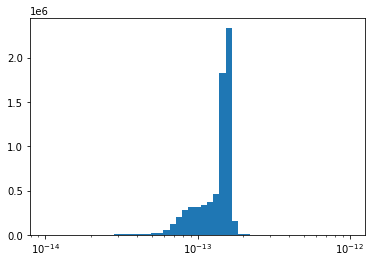

In [44]:
plt.hist(gammalist,bins=np.logspace(-14,-12))
plt.xscale("log")

In [45]:
np.median(gammalist)

1.4888220252234054e-13